<a href="https://colab.research.google.com/github/sami24191/Data-Visualization/blob/master/Time_Series_Forecasting_PJME_20240526.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [ ]:
df =  pd.read_csv("C:/Work_Files/Projects/pjme/data/PJME_hourly.csv")

In [ ]:
# upload data file

from google.colab import files
uploaded = files.upload()

Saving PJME_hourly.csv to PJME_hourly.csv


In [ ]:

import io
df = pd.read_csv(io.BytesIO(uploaded['PJME_hourly.csv']))
df.head(1)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0


In [ ]:

df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

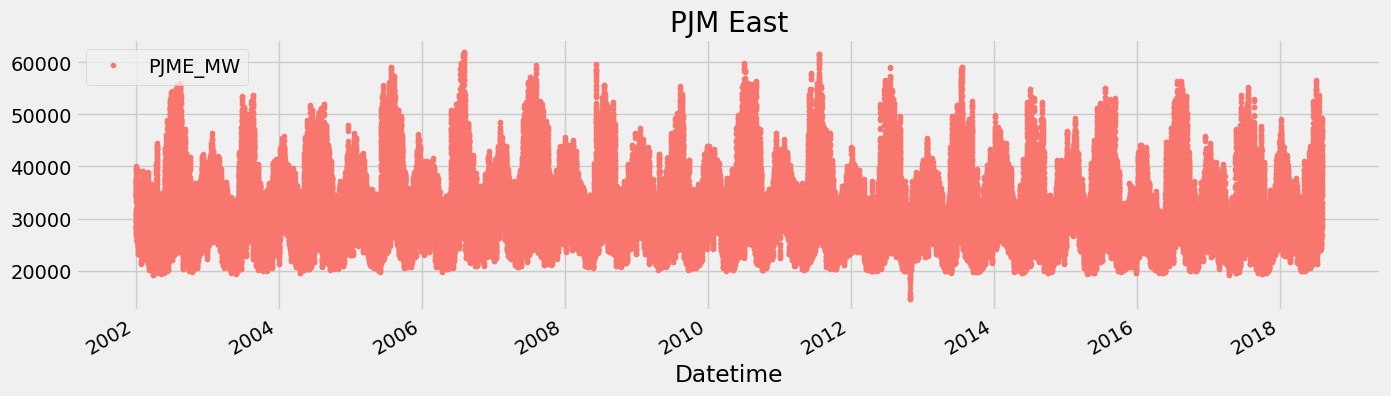

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,4), color=color_pal[0], title='PJM East')

## **Train/Test Split**

Cut off the data after 2015 to use as our validation set.

In [ ]:
split_date = '01-Jan-2015'
pjme_train = df.loc[df.index <= split_date].copy()
pjme_test = df.loc[df.index > split_date].copy()

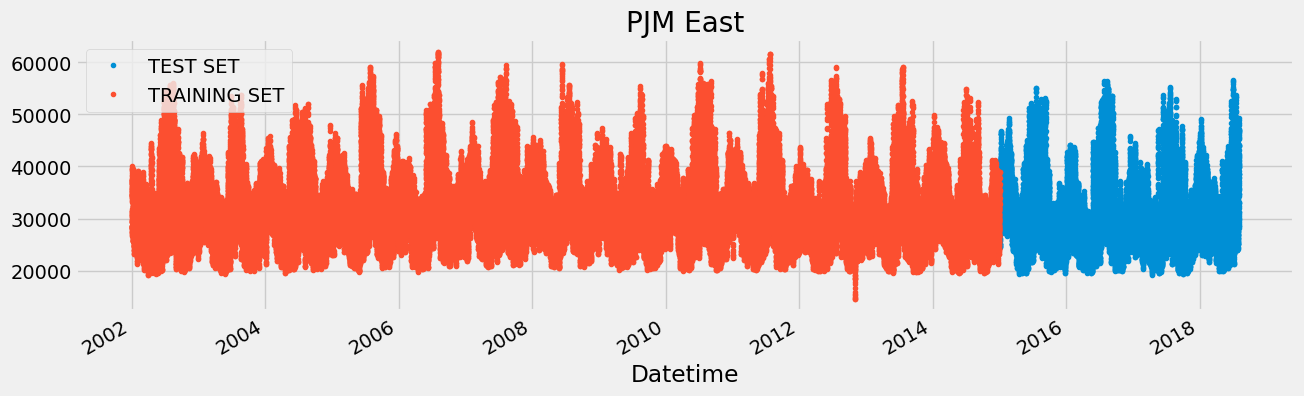

In [ ]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(14,4), title='PJM East', style='.')

## Create Time Series Features